In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

Lets start by creating a simple Neural Network we can use to explore activations

In [2]:
# New Neural Network
def preprocess_data(x_train, y_train, x_test, y_test, num_classes=10):
    x_train = x_train.reshape(-1, 784) / 255.0
    x_test = x_test.reshape(-1, 784) / 255.0
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

class MLPModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Flatten(input_shape=self.input_shape),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, epochs=5, batch_size=128):
        self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

Now lets implament a function to get the activations from our neural network and get some cool visuals

In [3]:
class NeuronActivationComputer:
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def compute_activations(self):
        num_classes = self.y_test.shape[-1]

        # Get the layer outputs for the test data
        layer_outputs = []
        for layer in self.model.layers:
            if hasattr(layer, 'output'):
                layer_model = tf.keras.Model(inputs=self.model.input, outputs=layer.output)
                layer_outputs.append(layer_model.predict(self.x_test))

        # Compute the neuron activations averaged for each label and each layer
        layer_activations = []
        for outputs in layer_outputs:
            num_neurons_in_layer = outputs.shape[-1]
            layer_activation = np.zeros((num_classes, num_neurons_in_layer))
            for label_idx in range(num_classes):
                layer_activation[label_idx] = np.mean(outputs[np.argmax(self.y_test, axis=1) == label_idx], axis=0)
            layer_activations.append(layer_activation)

        return layer_activations

    def visualize_activations(self, layer_idx, class_idx=None):
        layer_activations = self.compute_activations()
        activations = layer_activations[layer_idx]

        if class_idx is None:
            # Visualize activations for all classes
            fig, axs = plt.subplots(2, 5, figsize=(15, 10))
            axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

            for class_label, class_activations in enumerate(activations):
                # Convert activations to numpy array for plotting
                class_activations = np.array(class_activations)

                # Create a bar plot for the activations
                axs[class_label].bar(range(len(class_activations)), class_activations)
                axs[class_label].set_title(f'Activations for Class {class_label}')
                axs[class_label].set_xlabel('Activation Index')
                axs[class_label].set_ylabel('Activation Value')

            plt.tight_layout()
            plt.show()
        else:
            # Visualize activations for a specific class
            print(f"Class {class_idx}:")
            print(activations[class_idx])

    def visualize_activations_for_neuron(self, layer_idx, neuron_idx):
        layer_activations = self.compute_activations()
        activations = layer_activations[layer_idx]

        # Visualize the activations for the specified neuron
        neuron_activations = [class_activations[neuron_idx] for class_activations in activations]
        plt.bar(range(len(neuron_activations)), neuron_activations)
        plt.title(f'Activations for Neuron {neuron_idx}')
        plt.xlabel('Class Index')
        plt.ylabel('Activation Value')
        plt.show()

    def visualize_activations_for_layer(self, visual_type):
        layer_outputs = []
        for layer in self.model.layers:
            if hasattr(layer, 'output'):
                layer_model = tf.keras.Model(inputs=self.model.input, outputs=layer.output)
                layer_outputs.append(layer_model.predict(self.x_test))

        # Compute the neuron activations averaged for each label and each layer
        layer_activations = []
        for outputs in layer_outputs:
            num_neurons_in_layer = outputs.shape[-1]
            layer_activation = np.zeros((self.y_test.shape[-1], num_neurons_in_layer))
            for label_idx in range(self.y_test.shape[-1]):
                layer_activation[label_idx] = np.mean(outputs[np.argmax(self.y_test, axis=1) == label_idx], axis=0)
            layer_activations.append(layer_activation)

        # Visualize the activations for each layer
        if visual_type == 1:
            for layer in layer_activations:
                plt.figure(figsize=(5, 12))  # Set the initial figure size
                plt.matshow(layer, cmap='hot', interpolation='nearest', aspect=20)
                plt.gcf().set_figheight(5)
                plt.gcf().set_figwidth(30)
                plt.show()
        elif visual_type == 2:
            fig = plt.figure(figsize=(15, 10))

            gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
            ax0 = plt.subplot(gs[0, :])
            ax1 = plt.subplot(gs[1, 0])
            ax2 = plt.subplot(gs[1, 1])
            ax3 = plt.subplot(gs[1, 2])

            axes = [ax0, ax1, ax2, ax3]

            for i, ax in enumerate(axes):
                layer = layer_activations[i]
                im = ax.matshow(layer, cmap='hot', interpolation='nearest', aspect=10)
                ax.set_title(f'Layer {i+1} Activations')

            plt.tight_layout()
            plt.show()
        else:
            fig, axs = plt.subplots(4, 1, figsize=(30, 60))

            for i, layer in enumerate(layer_activations):
                im = axs[i].matshow(layer, cmap='hot', interpolation='nearest', aspect=20)
                axs[i].set_title(f'Layer {i+1} Activations')

            # Add a colorbar to the figure
            fig.colorbar(im, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.02)

            plt.tight_layout()
            plt.show()

    def visualize_activations_for_single_label(self, label_idx):
        layer_outputs = []
        for layer in self.model.layers:
            if hasattr(layer, 'output'):
                layer_model = tf.keras.Model(inputs=self.model.input, outputs=layer.output)
                layer_outputs.append(layer_model.predict(self.x_test))

        # Compute the neuron activations averaged for each label and each layer
        layer_activations = []
        for outputs in layer_outputs:
            num_neurons_in_layer = outputs.shape[-1]
            layer_activation = np.zeros((self.y_test.shape[-1], num_neurons_in_layer))
            for label_idx in range(self.y_test.shape[-1]):
                layer_activation[label_idx] = np.mean(outputs[np.argmax(self.y_test, axis=1) == label_idx], axis=0)
            layer_activations.append(layer_activation)

        # Visualize the activations for each layer
        fig = plt.figure(figsize=(15, 10))

        for i, layer_activation in enumerate(layer_activations):
            # Get the activations for the 4th label
            label_activation = layer_activation[4]  # Change this index if you want a different label

            # Create a subplot for this layer
            ax = fig.add_subplot(1, len(layer_activations), i+1)
            ax.plot(label_activation)
            ax.set_title(f'Layer {i+1} Activations')

        plt.tight_layout()
        plt.show()

    # Not sure what this is
    def analyze_activations(self, layer_idx, analysis_function):
        layer_activations = self.compute_activations()
        activations = layer_activations[layer_idx]

        # Apply the analysis function to the activations
        analysis_result = analysis_function(activations)

        return analysis_result

Now lets test that



Epoch 1/5


469/469 [==============================] - 2s 3ms/step - loss: 0.3285 - accuracy: 0.9078
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1351 - accuracy: 0.9597
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0917 - accuracy: 0.9727
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0689 - accuracy: 0.9784
Epoch 5/5
313/313 [==============================] - 0s 1ms/step


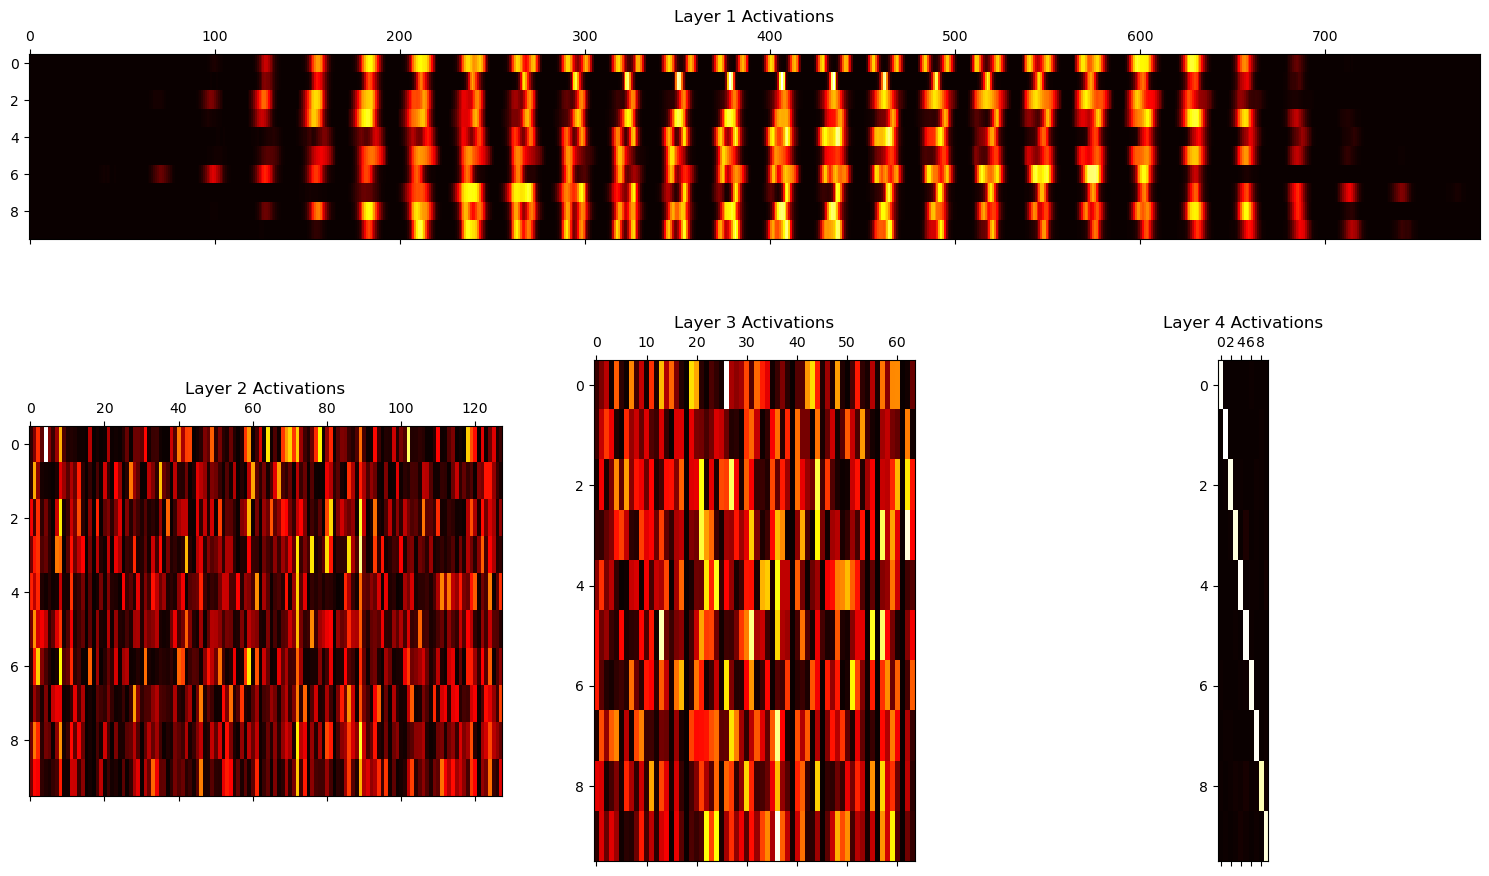

In [4]:
# Load your dataset
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

# Create an instance of the MLPModel
mlp_model = MLPModel(input_shape=(784,), num_classes=10)

# Train the model
mlp_model.train(x_train, y_train)

# Compute neuron activations
neuron_activation_computer = NeuronActivationComputer(mlp_model.model, x_test, y_test)
layer_activations = neuron_activation_computer.compute_activations()
neuron_activation_computer.visualize_activations_for_layer(2)
# neuron_activation_computer.visualize_activations_for_single_label(4)

Now I am going o go on a side track. Here my vision is to create a "Phantom 4" Where I perform data augmentation to remove the stalks from the 4s and then prove that I can sill recover the 4s with high accuracy using the ablation to elarn the stalk identification fromt the mean activation using PCA.

In [5]:
# Now Lets create a dataset of ablated 4s
# if not os.path.exists('4_dataset'):
#     os.makedirs('4_dataset', exist_ok=True)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

list_4s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 4]
ablated_list_4s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 4]

def find_best_line(image):
    row_sums = [sum(row) for row in image]
    max_row_idx = row_sums.index(max(row_sums))
    return max_row_idx

def ablated4(image, index):
    max_row_idx = find_best_line(image)
    image = image.reshape(28, 28)
    image[:, (max_row_idx-2):] = 0  # Fill between max_row_idx and 27 with black
    # np.save('7_dataset/abalated_image_' + str(index), image)

# Create the new dataset of stalked 4s
for index, image in enumerate(list_4s):
    ablated4(image, index)


(x_train, y_train), (x_test, y_test) = mnist.load_data()
list_4s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 4]

In [6]:
# make a directory 7_dataset
# if not os.path.exists('7_dataset'):
#     os.makedirs('7_dataset', exist_ok=True)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

list_7s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 7]
ablated_list_7s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 7]

def find_best_line(image):
    row_sums = [sum(row) for row in image]
    max_row_idx = row_sums.index(max(row_sums))
    return max_row_idx

def ablated7(image, index):
    max_row_idx = find_best_line(image)
    image = image.reshape(28, 28)
    image[:(max_row_idx+3), :] = 0  # Fill between max_row_idx and 27 with black
    image[:17, :13] = 0  # Fill between 0 and 17 with black in the range 0 to 12
    # plt.imshow(image, cmap='gray')
    # np.save('7_dataset/abalated_image_' + str(index), image)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
list_7s = [x_test[i] for i in range(len(x_test)) if y_test[i] == 7]   

for index, image in enumerate(ablated_list_7s):
    ablated7(image, index)

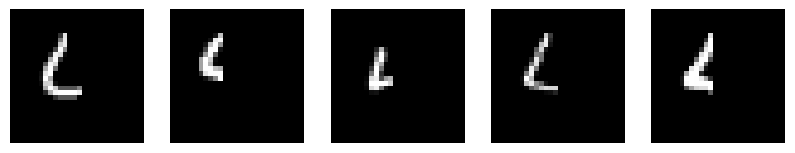

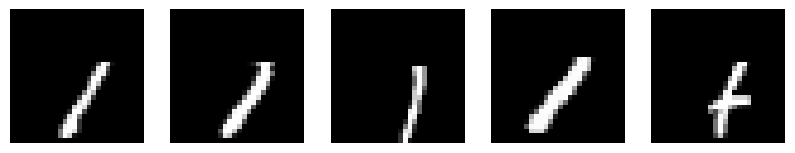

In [7]:
# show the first 5 images of the ablated 4s and 7s
ablation_data = [ablated_list_4s, ablated_list_7s]

for data in ablation_data:
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(data[i], cmap='gray')
        plt.axis('off')
    plt.show()


Now we can plug in our ablations and see the difference in activations

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3248 - accuracy: 0.9095
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1334 - accuracy: 0.9613
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0937 - accuracy: 0.9721
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0725 - accuracy: 0.9782
Epoch 5/5
31/31 [==============================] - 0s 866us/step


c:\Users\ryanp\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ryanp\anaconda3\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


31/31 [==============================] - 0s 2ms/step


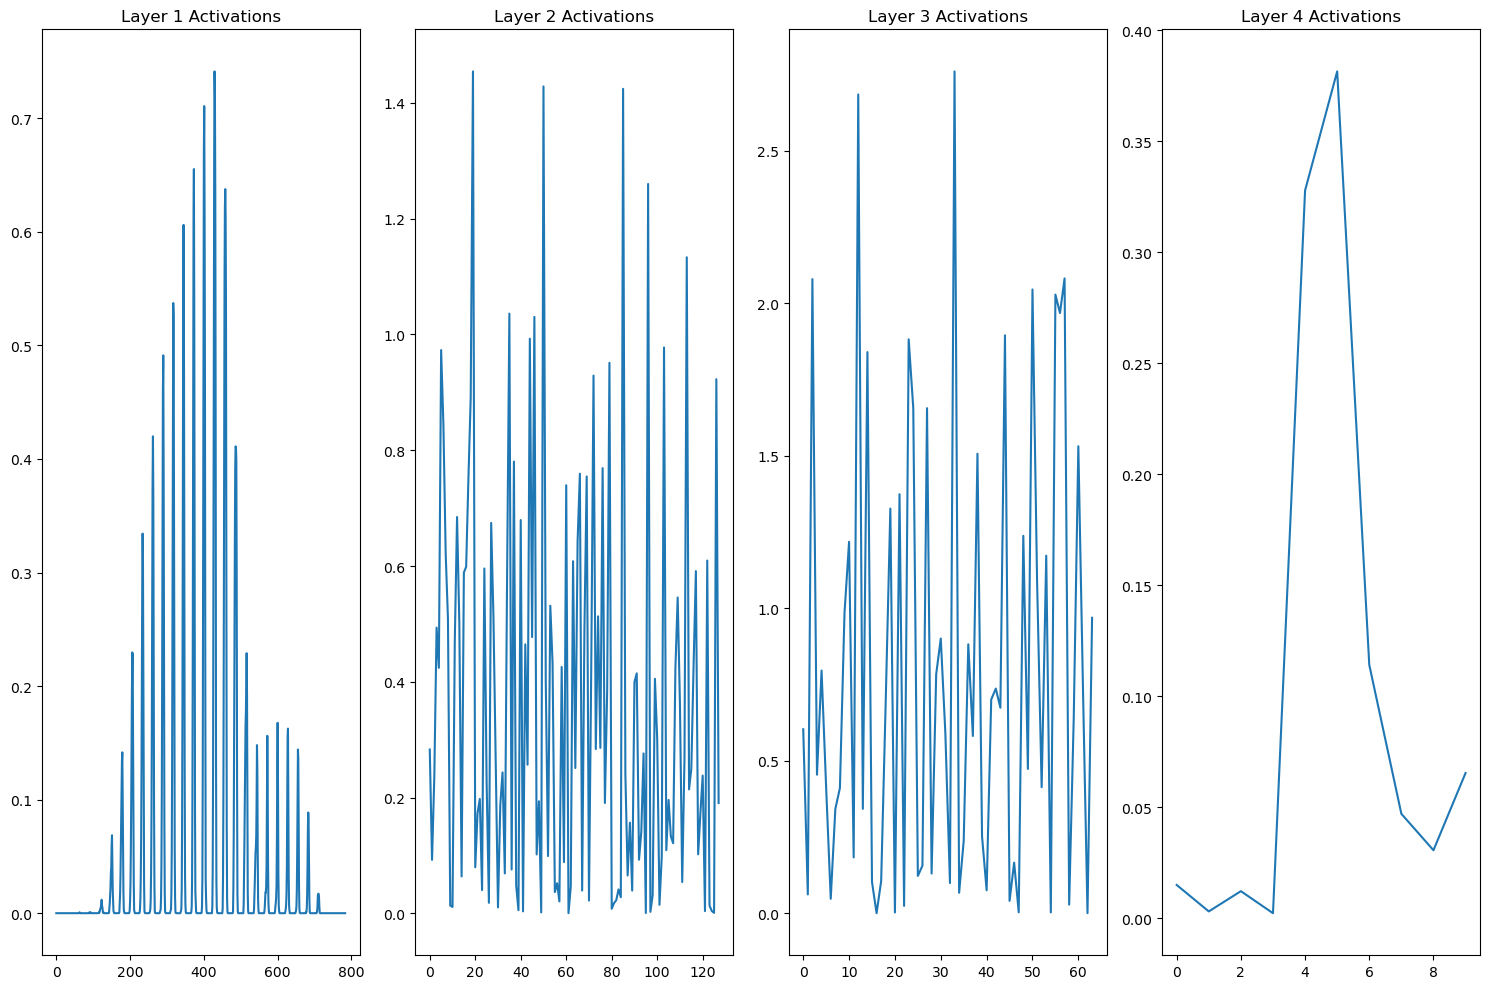

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = np.array(ablated_list_4s)
y_test = np.ones(len(ablated_list_4s)) * 4

# Preprocess the data
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

# Create an instance of the MLPModel
mlp_model = MLPModel(input_shape=(784,), num_classes=10)

# Train the model
mlp_model.train(x_train, y_train)

# Compute neuron activations
neuron_activation_computer = NeuronActivationComputer(mlp_model.model, x_test, y_test)
layer_activations = neuron_activation_computer.compute_activations()
# neuron_activation_computer.visualize_activations_for_layer(2)
neuron_activation_computer.visualize_activations_for_single_label(4)

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.3303 - accuracy: 0.9048
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1371 - accuracy: 0.9600
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0940 - accuracy: 0.9714
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0720 - accuracy: 0.9782
Epoch 5/5
313/313 [==============================] - 0s 1ms/step


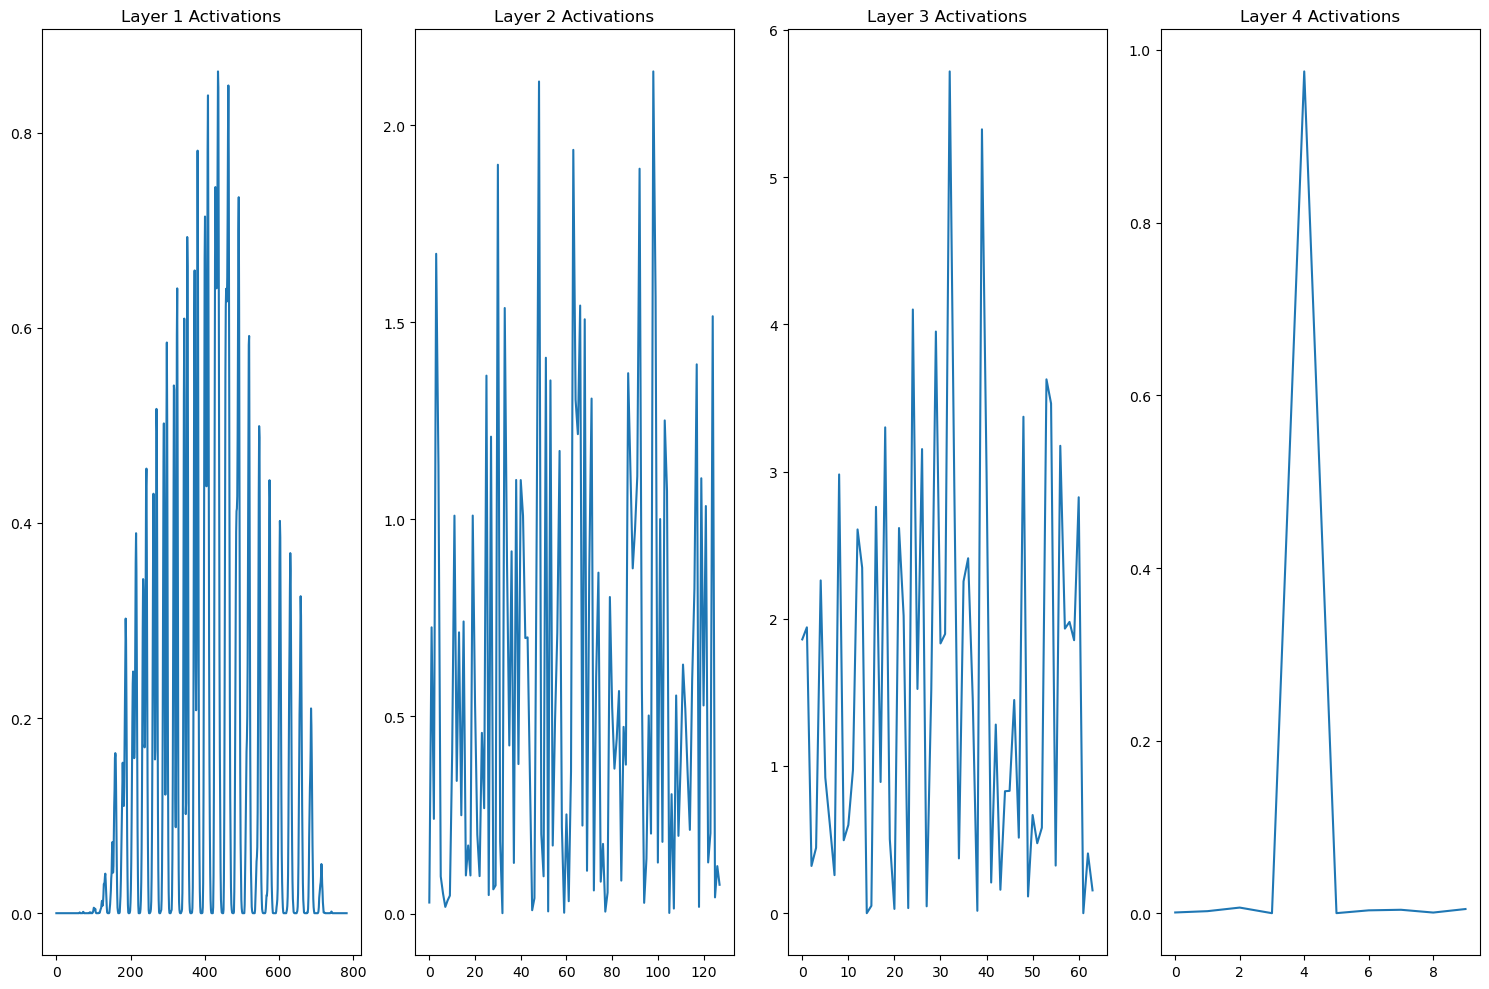

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

# Create an instance of the MLPModel
mlp_model = MLPModel(input_shape=(784,), num_classes=10)

# Train the model
mlp_model.train(x_train, y_train)

# Compute neuron activations
neuron_activation_computer = NeuronActivationComputer(mlp_model.model, x_test, y_test)
layer_activations = neuron_activation_computer.compute_activations()
# neuron_activation_computer.visualize_activations_for_layer(2)
neuron_activation_computer.visualize_activations_for_single_label(4)